In [1]:
import Random, Logging
using Gen, Plots

# Disable logging, because @animate is verbose otherwise
Logging.disable_logging(Logging.Info);

In [2]:
@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)
    
    # Next, we generate the actual y coordinates.
    n = length(xs)
    ys = Float64[]
    
    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 10.)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

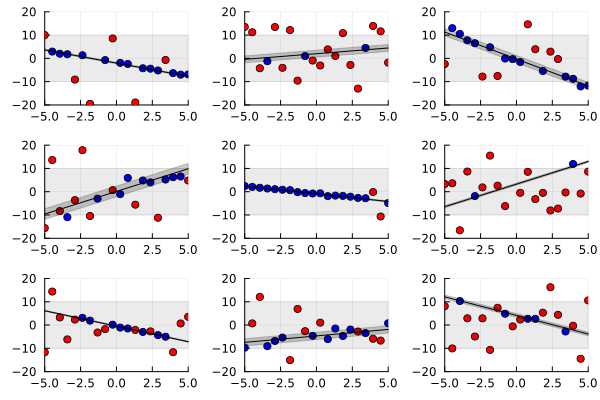

In [4]:
include("./visualization/regression_viz.jl")
xs     = collect(range(-5, stop=5, length=20))
traces = [Gen.simulate(regression_with_outliers, (xs,)) for i in 1:9];
Plots.plot([visualize_trace(t) for t in traces]...)

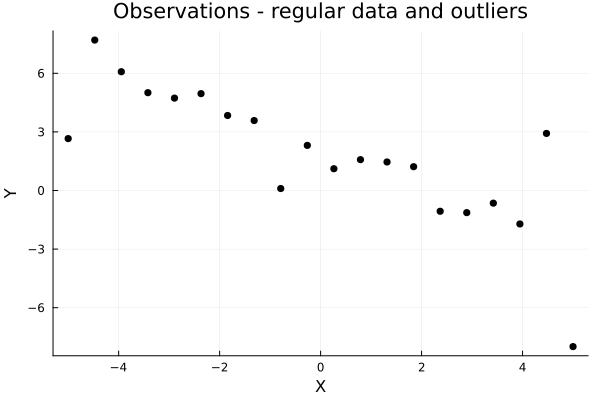

In [5]:
function make_synthetic_dataset(n)
    Random.seed!(1)
    prob_outlier = 0.2
    true_inlier_noise = 0.5
    true_outlier_noise = 5.0
    true_slope = -1
    true_intercept = 2
    xs = collect(range(-5, stop=5, length=n))
    ys = Float64[]
    for (i, x) in enumerate(xs)
        if rand() < prob_outlier
            y = randn() * true_outlier_noise
        else
            y = true_slope * x + true_intercept + randn() * true_inlier_noise
        end
        push!(ys, y)
    end
    (xs, ys)
end
    
(xs, ys) = make_synthetic_dataset(20);
Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y", 
              label=nothing, title="Observations - regular data and outliers")

In [6]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

In [7]:
observations = make_constraints(ys);

In [8]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

In [10]:
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

In [11]:
function block_resimulation_inference(xs, ys, observations)
    observations = make_constraints(ys)
    (tr, _) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:500
        tr = block_resimulation_update(tr)
    end
    tr
end;

Plots.AnimatedGif("/Users/nathanaeltu/Downloads/Slow_Problem/tmp.gif")
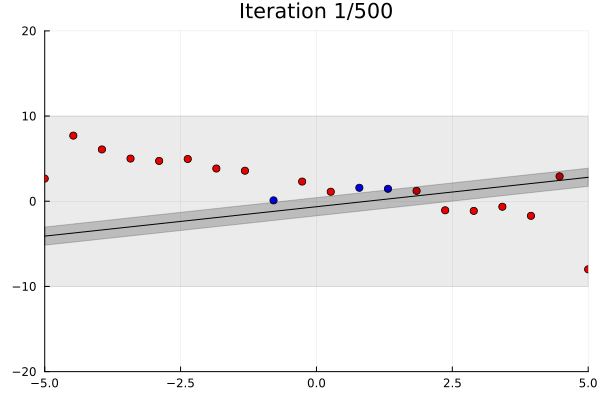

In [12]:
t, = generate(regression_with_outliers, (xs,), observations)

viz = Plots.@animate for i in 1:500
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/500")
end;
gif(viz)

In [13]:
@gen function line_proposal(current_trace)
    slope ~ normal(current_trace[:slope], 0.5)
    intercept ~ normal(current_trace[:intercept], 0.5)
end;

In [14]:
function gaussian_drift_update(tr)
    # Gaussian drift on line params
    (tr, _) = mh(tr, line_proposal, ())
    
    # Block resimulation: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block resimulation: Update the prob_outlier parameter
    (tr, w) = mh(tr, select(:prob_outlier))
    (tr, w) = mh(tr, select(:noise))
    tr
end;

Plots.AnimatedGif("/Users/nathanaeltu/Downloads/Slow_Problem/tmp.gif")
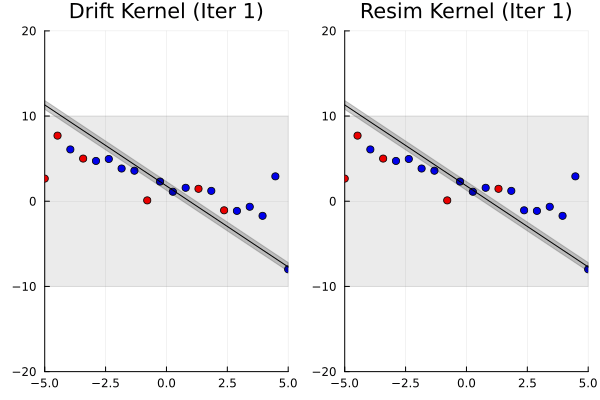

In [15]:
tr1, = generate(regression_with_outliers, (xs,), observations)
tr2 = tr1

viz = Plots.@animate for i in 1:300
    global tr1, tr2
    tr1 = gaussian_drift_update(tr1)
    tr2 = block_resimulation_update(tr2)
    Plots.plot(visualize_trace(tr1; title="Drift Kernel (Iter $i)"), 
               visualize_trace(tr2; title="Resim Kernel (Iter $i)"))
end;
gif(viz)